# Use ASF Search to find SAR data from Sentinel-1

In [1]:
import asf_search as asf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import glob
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import rasterio
from scipy.ndimage import zoom
from scipy.interpolate import griddata
import xml.etree.ElementTree as ET

In [2]:
# geo_results[0].download(path="../data/sentinel-1", session=session)

### Load data file

In [3]:
file_glob = glob.glob("../data/sentinel-1/*/measurement/*.tiff")

In [31]:
# Select .tiff file and get data
file_path = file_glob[0]
print(file_path)
file_path_p = Path(file_path)
print(file_path_p)

file_stem = file_path_p.stem
print(file_stem)

../data/sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\measurement\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.tiff
..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\measurement\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.tiff
s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001


### Locate and load product summary file

In [32]:
product_path = file_path_p.parent.parent
print(product_path)
preview_path = product_path.joinpath("preview")
print(preview_path)
kml_files = glob.glob(f"{str(preview_path)}/*.kml")
kml_file = kml_files[0]
print(kml_file)

..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE
..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\preview
..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\preview\map-overlay.kml


### Locate and load annotation file associated with tiff data

In [33]:
# Find annotation data for measurement file
annotation_path = product_path / "annotation"
annotation_file = annotation_path / f"{file_stem}.xml"
print(annotation_file)

..\data\sentinel-1\S1A_IW_SLC__1SDV_20180606T141441_20180606T141508_022237_0267EB_EC03.SAFE\annotation\s1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001.xml


### Find coordinate locations of each measurement point from data file

In [34]:
# Load XML and geolocation grid
ann_tree = ET.parse(annotation_file)
ann_root = ann_tree.getroot()
glg_element = ann_root.find("geolocationGrid")
glgpl_element = glg_element.find("geolocationGridPointList")

geolocation_points = []
for i, point in enumerate(glgpl_element.findall("geolocationGridPoint")):
    line = int(point.find("line").text)
    pixel = int(point.find("pixel").text)
    lat = float(point.find("latitude").text)
    lon = float(point.find("longitude").text)
    geolocation_points.append((line, pixel, lat, lon))

geolocation_array = np.array(geolocation_points)
print(f"{geolocation_array.shape = }")
lines = geolocation_array[:, 0]
pixels = geolocation_array[:, 1]
lats = geolocation_array[:, 2]
lons = geolocation_array[:, 3]

geolocation_array.shape = (210, 4)


In [35]:
print(geolocation_array[:5, :])

[[   0.            0.           42.59359434 -120.4492047 ]
 [   0.         1060.           42.60177995 -120.50675514]
 [   0.         2120.           42.60985781 -120.56376294]
 [   0.         3180.           42.61783168 -120.62024845]
 [   0.         4240.           42.62570509 -120.67623085]]


In [36]:
print(np.min(lats))
print(np.max(lats))

41.08364918328356
42.74025269372995


In [37]:
print(np.min(lons))
print(np.max(lons))

-121.8810175432298
-120.4492046987991


189
[  41.08364918 -120.83964114]
[  42.74025269 -121.51561604]
[  41.23010369 -121.88101754]
[  42.59359434 -120.4492047 ]
[[13472.             0.            41.08364918  -120.83964114]
 [    0.         21197.            42.74025269  -121.51561604]
 [13472.         21197.            41.23010369  -121.88101754]
 [    0.             0.            42.59359434  -120.4492047 ]]
[[  41.08364918 -120.83964114]
 [  42.74025269 -121.51561604]
 [  41.23010369 -121.88101754]
 [  42.59359434 -120.4492047 ]]


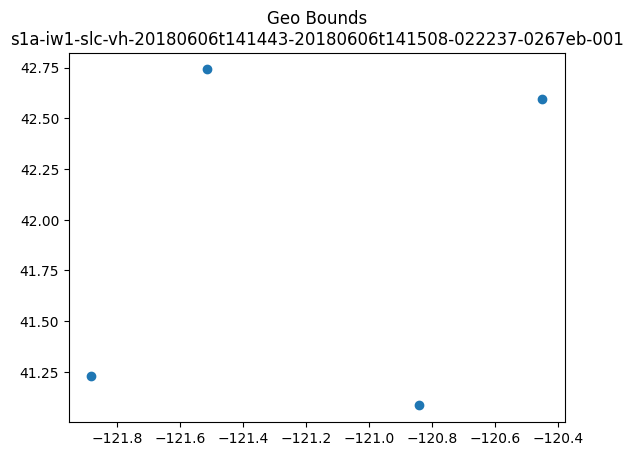

In [47]:
print(np.argmin(lats))
four_corners = [np.argmin(lats), np.argmax(lats), np.argmin(lons), np.argmax(lons)]
print(geolocation_array[np.argmin(lats), 2:])
print(geolocation_array[np.argmax(lats), 2:])
print(geolocation_array[np.argmin(lons), 2:])
print(geolocation_array[np.argmax(lons), 2:])
print(np.take(geolocation_array, four_corners, axis=0))
print(np.take(geolocation_array, four_corners, axis=0)[:, 2:])
plt.scatter(np.take(geolocation_array, four_corners, axis=0)[:, 3], np.take(geolocation_array, four_corners, axis=0)[:, 2])
plt.title(f"Geo Bounds\n{file_stem}")
plt.show()

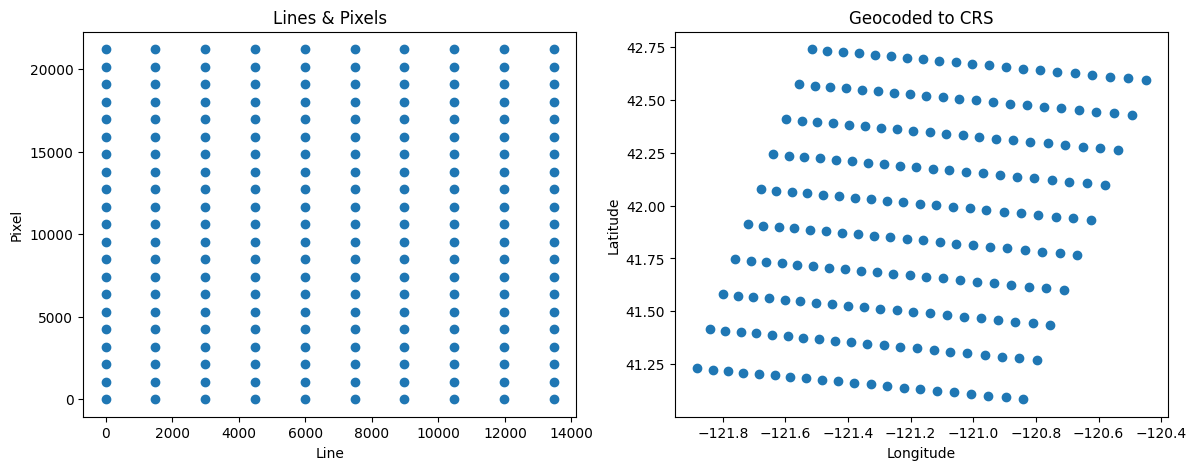

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(lines, pixels)
axs[0].set_xlabel("Line")
axs[0].set_ylabel("Pixel")
axs[0].set_title("Lines & Pixels")

axs[1].scatter(lons, lats)
axs[1].set_xlabel("Longitude")
axs[1].set_ylabel("Latitude")
axs[1].set_title("Geocoded to CRS")
plt.show()

In [9]:
tree = ET.parse(kml_file)
root = tree.getroot()
namespaces = {"gx": "http://www.google.com/kml/ext/2.2"}
coordinates_tag = root.find(".//gx:LatLonQuad/coordinates", namespaces)
coordinates_text = coordinates_tag.text.strip()
coordinates = [
    tuple(map(float, coord.split(","))) for coord in coordinates_text.split()
]

print(coordinates)

[(-120.842606, 41.083923), (-123.8255, 41.476665), (-123.48111, 43.094376), (-120.418518, 42.702103)]


### Load TIFF data into numpy array

In [10]:
with rasterio.open(file_path, "r") as src:
    print(type(src))
    print(src.__dict__.items())
    print(f"{src.crs = }")
    sar_data = src.read(1)
    print(type(sar_data))
    print(sar_data.shape)
    transform = src.transform
    bounds = src.bounds
    print(f"{bounds = }")

<class 'rasterio.io.DatasetReader'>
dict_items([])
src.crs = None
<class 'numpy.ndarray'>
(13473, 21198)
bounds = BoundingBox(left=0.0, bottom=13473.0, right=21198.0, top=0.0)


In [11]:
sar_data_shape = sar_data.shape

print(f"{lines.shape = }")
print(f"{pixels.shape = }")

target_lines, target_pixels = np.meshgrid(np.arange(sar_data_shape[0]), np.arange(sar_data_shape[1]), indexing="ij")
print(f"{target_lines.shape = }")
print(f"{target_pixels.shape = }")

grid_lat = griddata((lines, pixels), lats, (target_lines, target_pixels), method="linear")
grid_lon = griddata((lines, pixels), lons, (target_lines, target_pixels), method="linear")
print(f"{grid_lat.shape = }")
print(f"{grid_lon.shape = }")

lines.shape = (210,)
pixels.shape = (210,)
target_lines.shape = (13473, 21198)
target_pixels.shape = (13473, 21198)
grid_lat.shape = (13473, 21198)
grid_lon.shape = (13473, 21198)


In [13]:
bound_coords = coordinates

In [12]:
print(f"{sar_data.nbytes / 1024 / 1024:0.1f} MB")

2179.0 MB


In [13]:
sar_data_magnitude = np.abs(sar_data)
print(sar_data_magnitude.dtype)

float32


In [18]:
n = -1
n_reduce = 500
grid_lon_flat = grid_lon[:n, :n].flatten()[::n_reduce]
grid_lat_flat = grid_lat[:n, :n].flatten()[::n_reduce]
sar_data_flat = sar_data_magnitude[:n, :n].flatten()[::n_reduce]

In [24]:
print(annotation_file.stem[:14])

s1a-iw1-slc-vh


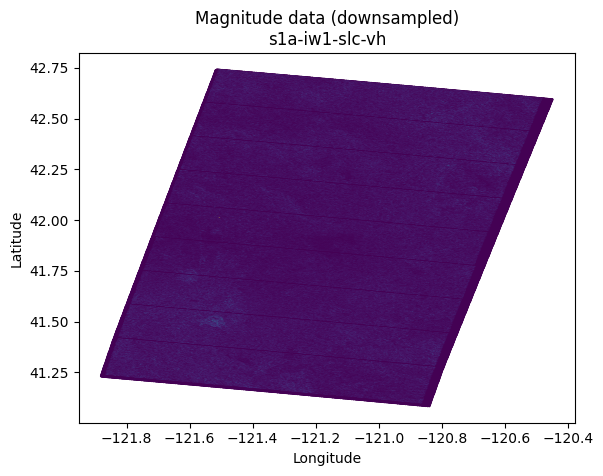

In [26]:
plt.scatter(grid_lon_flat, grid_lat_flat, c=sar_data_flat, s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Magnitude data (downsampled)\n{annotation_file.stem[:14]}")
plt.show()

i = 0
file_stem = 's1a-iw1-slc-vh-20180606t141443-20180606t141508-022237-0267eb-001'
Locating geo points
geolocation_array.shape = (210, 4)
Loading raster data
src.crs = None
sar_data.shape = (13473, 21198)
Interpolating geo grid points
Taking magnitude and downsampling plot data
Plotting data...
i = 1
file_stem = 's1a-iw1-slc-vv-20180606t141443-20180606t141508-022237-0267eb-004'
Locating geo points
geolocation_array.shape = (210, 4)
Loading raster data
src.crs = None
sar_data.shape = (13473, 21198)
Interpolating geo grid points
Taking magnitude and downsampling plot data
Plotting data...
i = 2
file_stem = 's1a-iw2-slc-vh-20180606t141441-20180606t141507-022237-0267eb-002'
Locating geo points
geolocation_array.shape = (210, 4)
Loading raster data
src.crs = None
sar_data.shape = (13581, 25122)
Interpolating geo grid points
Taking magnitude and downsampling plot data
Plotting data...
i = 3
file_stem = 's1a-iw2-slc-vv-20180606t141441-20180606t141507-022237-0267eb-005'
Locating geo points
g

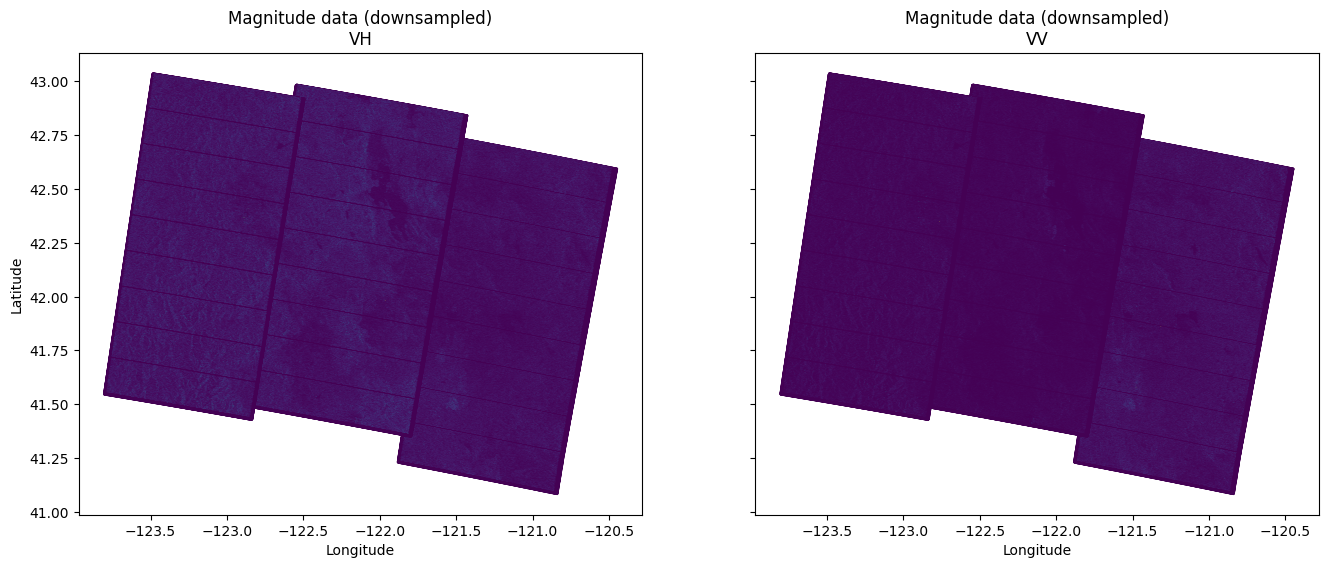

In [30]:
n_reduce = 500

fig, axs = plt.subplots(1, 2, sharey="row", figsize=(16, 6))

for i, data_file in enumerate(file_glob):
    print(f"{i = }")
    data_file_p = Path(data_file)
    file_stem = data_file_p.stem
    print(f"{file_stem = }")
    product_path = data_file_p.parent.parent
    annotation_path = product_path / "annotation"
    annotation_file = annotation_path / f"{file_stem}.xml"

    # Load XML and geolocation grid
    ann_tree = ET.parse(annotation_file)
    ann_root = ann_tree.getroot()
    glg_element = ann_root.find("geolocationGrid")
    glgpl_element = glg_element.find("geolocationGridPointList")

    print(f"Locating geo points")
    
    geolocation_points = []
    for i, point in enumerate(glgpl_element.findall("geolocationGridPoint")):
        line = int(point.find("line").text)
        pixel = int(point.find("pixel").text)
        lat = float(point.find("latitude").text)
        lon = float(point.find("longitude").text)
        geolocation_points.append((line, pixel, lat, lon))
    
    geolocation_array = np.array(geolocation_points)
    print(f"{geolocation_array.shape = }")
    lines = geolocation_array[:, 0]
    pixels = geolocation_array[:, 1]
    lats = geolocation_array[:, 2]
    lons = geolocation_array[:, 3]

    print(f"Loading raster data")
    with rasterio.open(data_file, "r") as src:
        print(f"{src.crs = }")
        sar_data = src.read(1)
        print(f"{sar_data.shape = }")
        transform = src.transform
        bounds = src.bounds

    sar_data_shape = sar_data.shape

    print(f"Interpolating geo grid points")
    target_lines, target_pixels = np.meshgrid(np.arange(sar_data_shape[0]), np.arange(sar_data_shape[1]), indexing="ij")
    
    grid_lat = griddata((lines, pixels), lats, (target_lines, target_pixels), method="linear")
    grid_lon = griddata((lines, pixels), lons, (target_lines, target_pixels), method="linear")

    print(f"Taking magnitude and downsampling plot data")
    sar_data_magnitude = np.abs(sar_data)

    grid_lon_flat = grid_lon[:n, :n].flatten()[::n_reduce]
    grid_lat_flat = grid_lat[:n, :n].flatten()[::n_reduce]
    sar_data_flat = sar_data_magnitude[:n, :n].flatten()[::n_reduce]

    print(f"Plotting data...")
    if "-vv-" in file_stem:
        ax_ind = 1
    elif "-vh-" in file_stem:
        ax_ind = 0
    else:
        print(f"'-vv-' or '-vh-' not detected!")
        continue
    axs[ax_ind].scatter(grid_lon_flat, grid_lat_flat, c=sar_data_flat, s=1)
axs[0].set_xlabel("Longitude")
axs[0].set_ylabel("Latitude")
axs[1].set_xlabel("Longitude")
axs[0].set_title(f"Magnitude data (downsampled)\nVH")
axs[1].set_title(f"Magnitude data (downsampled)\nVV")
plt.show()

In [18]:
# plot_bounds = (bounds.left, bounds.right, bounds.bottom, bounds.top)
bc_np = np.array(bound_coords)
left = np.min(bc_np[:, 0])
right = np.max(bc_np[:, 0])
bottom = np.min(bc_np[:, 1])
top = np.max(bc_np[:, 1])

plot_bounds = (left, right, bottom, top)
print(plot_bounds)

(np.float64(-123.8255), np.float64(-120.418518), np.float64(41.083923), np.float64(43.094376))


sar_data_magnitude.shape = (13473, 21198)
0.0
1951.7787
5918609


C:\Users\alakocy\AppData\Local\Temp\ipykernel_9588\2900570708.py:6: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(sar_data_magnitude))  #, cmap="gray")  #, extent=plot_bounds)


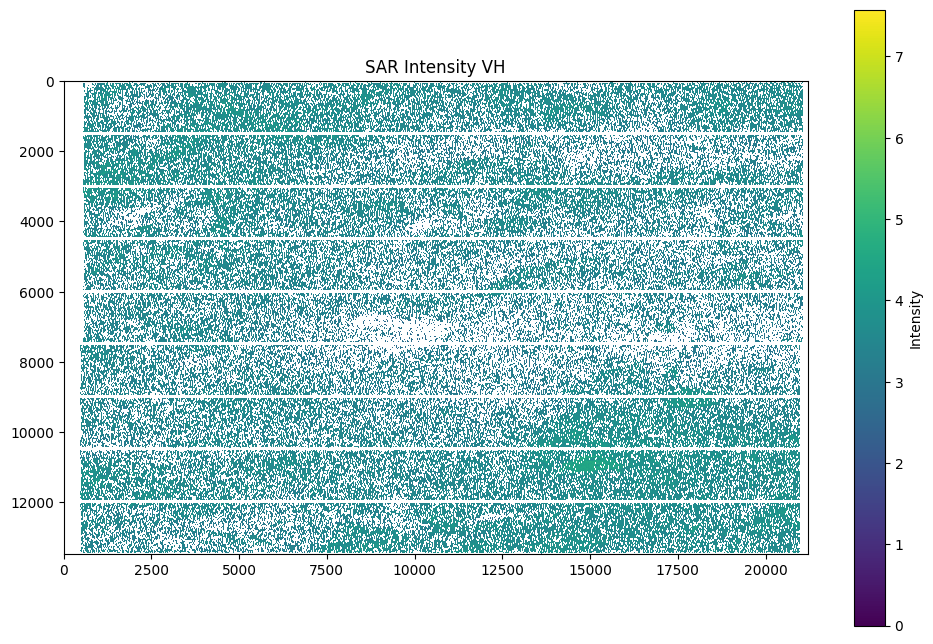

In [19]:
print(f"{sar_data_magnitude.shape = }")
print(np.min(sar_data_magnitude))
print(np.max(sar_data_magnitude))
print(np.count_nonzero(sar_data_magnitude > 100))
plt.figure(figsize=(12, 8))
plt.imshow(np.log(sar_data_magnitude))  #, cmap="gray")  #, extent=plot_bounds)
plt.colorbar(label="Intensity")
plt.title("SAR Intensity VH")
plt.show()

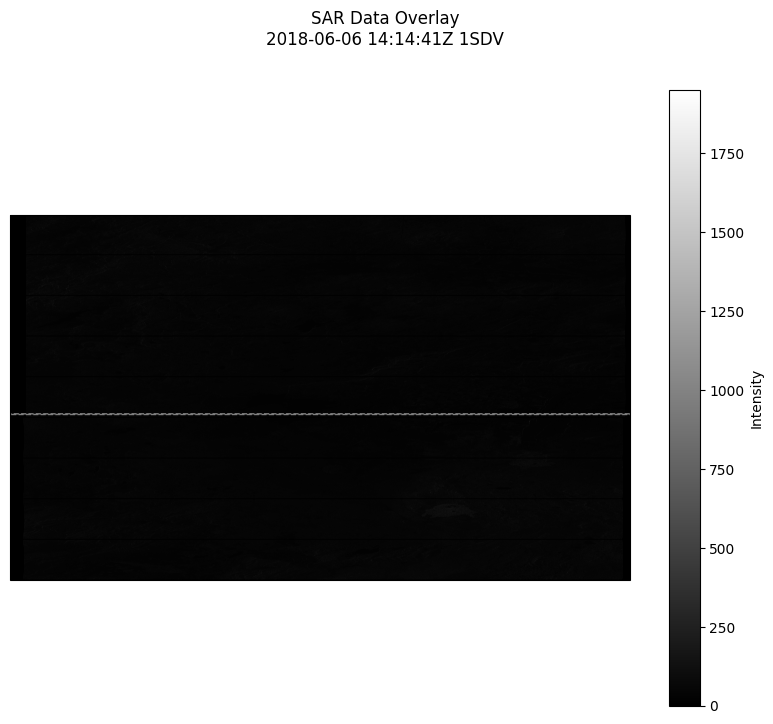

In [20]:
pc_crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": pc_crs})
ax.set_extent(plot_bounds, crs=pc_crs)
img = ax.imshow(sar_data_magnitude, cmap="gray", extent=plot_bounds, transform=pc_crs)

ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.STATES, linestyle="--", edgecolor="gray")

fig.suptitle("SAR Data Overlay\n2018-06-06 14:14:41Z 1SDV")
plt.colorbar(img, ax=ax, orientation="vertical", label="Intensity")
plt.show()

In [80]:
block_size = 10
downsample_factor = 1 / block_size
sar_data_zoom = zoom(sar_data_magnitude, downsample_factor)

In [81]:
print(f"{sar_data_zoom.nbytes / 1024 / 1024:0.1f} MB")

10.9 MB


In [82]:
def manual_downsample(data: np.ndarray, block_size: int) -> np.ndarray:
    orig_shape = data.shape
    new_shape = tuple([data.shape[0] // block_size, block_size, data.shape[1] // block_size, block_size])
    return data[:new_shape[0] * block_size, :new_shape[2] * block_size].reshape(new_shape).mean(axis=(1, 3))

In [83]:
sar_data_downsample = manual_downsample(sar_data_magnitude, block_size)

In [84]:
print(f"{sar_data_downsample.nbytes / 1024 / 1024:0.1f} MB")

10.9 MB


In [85]:
new_transform = rasterio.Affine(
    transform.a / downsample_factor, transform.b, transform.c,
    transform.d, transform.e / downsample_factor, transform.f,
)

In [87]:
# new_width = int((bounds.right - bounds.left) / (transform.a * downsample_factor))
new_width = int((right - left) / (transform.a * downsample_factor))
# new_height = int((bounds.top - bounds.bottom) / (-transform.e * downsample_factor))
new_height = int((top - bottom) / (-transform.e * downsample_factor))

new_bounds = rasterio.transform.array_bounds(new_height, new_width, new_transform)
# print(f"{bounds = }")
print(f"{plot_bounds = }")
print(f"{new_bounds = }")

plot_bounds = (np.float64(-123.8255), np.float64(-120.418518), np.float64(41.083923), np.float64(43.094376))
new_bounds = (0.0, -200.0, 340.0, 0.0)


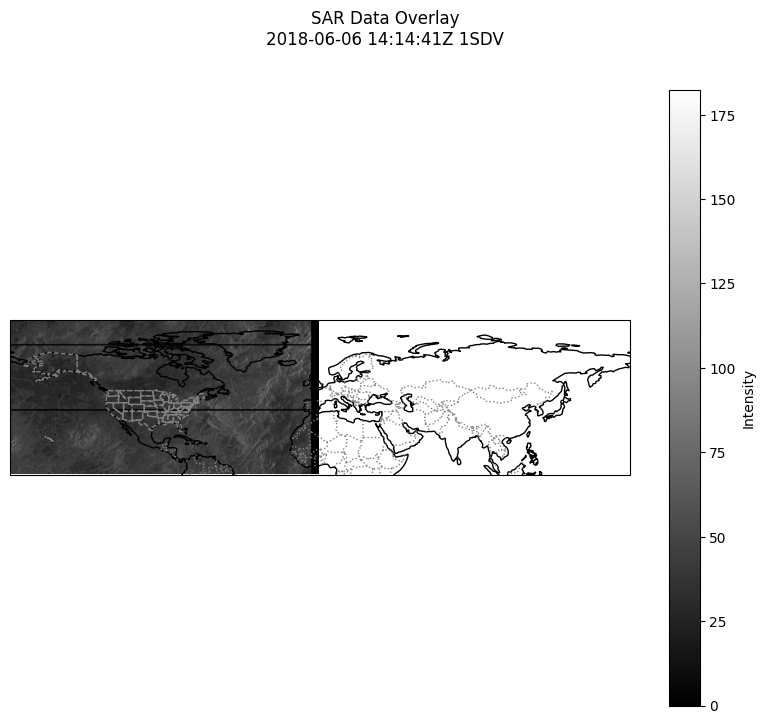

In [88]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent(new_bounds, crs=ccrs.PlateCarree())
img = ax.imshow(sar_data_downsample, cmap="gray", extent=new_bounds, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor="black")
ax.add_feature(cfeature.BORDERS, linestyle=":", edgecolor="gray")
ax.add_feature(cfeature.STATES, linestyle="--", edgecolor="gray")

fig.suptitle("SAR Data Overlay\n2018-06-06 14:14:41Z 1SDV")
plt.colorbar(img, ax=ax, orientation="vertical", label="Intensity")
plt.show()